In [301]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

## Import data

In [302]:
X_train_original = pd.read_pickle('data/X_train_scaled.pkl')
X_test_original = pd.read_pickle('data/X_test_scaled.pkl')
y_train_common = pd.read_pickle('data/y_train_common.pkl')
y_train_motor = pd.read_pickle('data/y_train_motor.pkl')
y_train_total = pd.read_pickle('data/y_train_total.pkl')
y_test_common = pd.read_pickle('data/y_test_common.pkl')
y_test_motor = pd.read_pickle('data/y_test_motor.pkl')
y_test_total = pd.read_pickle('data/y_test_total.pkl')

# Feature Engineering
We will add more features based on domain knowledge or by extracting from other features that can help give better predictions.

After carefully understanding the features, we divided them in meaningful subgroups to analyze. 

In [303]:
feature_groups = {
    'jitter': ['Jitter(%)', 'Jitter(Abs)', 'Jitter:RAP', 'Jitter:PPQ5', 'Jitter:DDP'],
    'shimmer': ['Shimmer', 'Shimmer:APQ3', 'Shimmer:APQ5', 'Shimmer:APQ11', 'Shimmer:DDA', 'Shimmer(dB)'],
    'noise': ['NHR', 'HNR'],
    'nonlinear': ['RPDE', 'DFA', 'PPE']
}

In [304]:
def create_subgroup_aggregates(X, feature_groups):
    """
    Creates mean/std features for each clinically defined subgroup
    """
    X_engineered = X.copy()
    
    for group_name, features in feature_groups.items():
        # Use only features present in the DataFrame
        valid_features = [f for f in features if f in X.columns]
        
        if valid_features:  # Check if features exist
            X_engineered[f'{group_name}_mean'] = X[valid_features].mean(axis=1)
            X_engineered[f'{group_name}_std'] = X[valid_features].std(axis=1)
    
    return X_engineered

# Apply to train and test sets
X_train_engineered = create_subgroup_aggregates(X_train_original, feature_groups)
X_test_engineered = create_subgroup_aggregates(X_test_original, feature_groups)

In [305]:
# voice specific global measures
# combine all of the voice features to get a singe measure of voice instability

voice_features = feature_groups['jitter'] + feature_groups['shimmer'] + feature_groups['noise']
X_train_engineered['voice_instability'] = X_train_original[voice_features].mean(axis=1)
X_test_engineered['voice_instability'] = X_test_original[voice_features].mean(axis=1)

In [306]:
X_test_engineered.columns

Index(['sex', 'Jitter(%)', 'Jitter(Abs)', 'Jitter:RAP', 'Jitter:PPQ5',
       'Jitter:DDP', 'Shimmer', 'Shimmer:APQ3', 'Shimmer:APQ5',
       'Shimmer:APQ11', 'Shimmer:DDA', 'NHR', 'RPDE', 'DFA', 'PPE', 'age',
       'test_time', 'Shimmer(dB)', 'HNR', 'jitter_mean', 'jitter_std',
       'shimmer_mean', 'shimmer_std', 'noise_mean', 'noise_std',
       'nonlinear_mean', 'nonlinear_std', 'voice_instability'],
      dtype='object')

## Interaction Features

In [307]:
interaction_pairs = [
    # Voice instability
    ('Jitter(%)', 'Shimmer'),
    ('Jitter:RAP', 'Shimmer:APQ3'),
    ('NHR', 'HNR'),
    # Nonlinear dynamics
    ('RPDE', 'PPE'),
    ('DFA', 'age'),
    # Time-dependent
    ('test_time', 'Jitter(%)'),
    ('test_time', 'RPDE'),
    # Demographic
    ('age', 'sex'),
    # subgroup aggregates
    ('jitter_std', 'shimmer_std'),
    ('noise_mean', 'nonlinear_std'),
    ('voice_instability', 'age')
]

In [308]:
def create_interactions(X, interaction_pairs):
    """Create clinically relevant interaction terms"""
    X_new = X.copy()
    for f1, f2 in interaction_pairs:
        if f1 in X.columns and f2 in X.columns:
            X_new[f'{f1}_x_{f2}'] = X[f1] * X[f2]
    return X_new

X_train_engineered = create_interactions(X_train_engineered, interaction_pairs)
X_test_engineered = create_interactions(X_test_engineered, interaction_pairs)

In [309]:
X_train_engineered.columns

Index(['sex', 'Jitter(%)', 'Jitter(Abs)', 'Jitter:RAP', 'Jitter:PPQ5',
       'Jitter:DDP', 'Shimmer', 'Shimmer:APQ3', 'Shimmer:APQ5',
       'Shimmer:APQ11', 'Shimmer:DDA', 'NHR', 'RPDE', 'DFA', 'PPE', 'age',
       'test_time', 'Shimmer(dB)', 'HNR', 'jitter_mean', 'jitter_std',
       'shimmer_mean', 'shimmer_std', 'noise_mean', 'noise_std',
       'nonlinear_mean', 'nonlinear_std', 'voice_instability',
       'Jitter(%)_x_Shimmer', 'Jitter:RAP_x_Shimmer:APQ3', 'NHR_x_HNR',
       'RPDE_x_PPE', 'DFA_x_age', 'test_time_x_Jitter(%)', 'test_time_x_RPDE',
       'age_x_sex', 'jitter_std_x_shimmer_std', 'noise_mean_x_nonlinear_std',
       'voice_instability_x_age'],
      dtype='object')

## Polynomial Features

In [310]:
polynomial_features = [
    'Jitter(%)',
    'Shimmer',
    'NHR',
    'PPE',
    'DFA'
]

In [311]:
def create_polynomials(X, features, degree=2):
    """Add polynomial features for selected columns"""
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    poly_features = poly.fit_transform(X[features])
    feature_names = poly.get_feature_names_out(features)

    # Remove original features to avoid redundancy
    X = X.drop(columns=features, errors='ignore')
    return pd.concat([X, pd.DataFrame(poly_features, columns=feature_names, index=X.index)], axis=1)

X_train_engineered = create_polynomials(X_train_engineered, polynomial_features)
X_test_engineered = create_polynomials(X_test_engineered, polynomial_features)

In [312]:
X_train_engineered.columns

Index(['sex', 'Jitter(Abs)', 'Jitter:RAP', 'Jitter:PPQ5', 'Jitter:DDP',
       'Shimmer:APQ3', 'Shimmer:APQ5', 'Shimmer:APQ11', 'Shimmer:DDA', 'RPDE',
       'age', 'test_time', 'Shimmer(dB)', 'HNR', 'jitter_mean', 'jitter_std',
       'shimmer_mean', 'shimmer_std', 'noise_mean', 'noise_std',
       'nonlinear_mean', 'nonlinear_std', 'voice_instability',
       'Jitter(%)_x_Shimmer', 'Jitter:RAP_x_Shimmer:APQ3', 'NHR_x_HNR',
       'RPDE_x_PPE', 'DFA_x_age', 'test_time_x_Jitter(%)', 'test_time_x_RPDE',
       'age_x_sex', 'jitter_std_x_shimmer_std', 'noise_mean_x_nonlinear_std',
       'voice_instability_x_age', 'Jitter(%)', 'Shimmer', 'NHR', 'PPE', 'DFA',
       'Jitter(%)^2', 'Jitter(%) Shimmer', 'Jitter(%) NHR', 'Jitter(%) PPE',
       'Jitter(%) DFA', 'Shimmer^2', 'Shimmer NHR', 'Shimmer PPE',
       'Shimmer DFA', 'NHR^2', 'NHR PPE', 'NHR DFA', 'PPE^2', 'PPE DFA',
       'DFA^2'],
      dtype='object')

In [313]:
redundant_features = [
    'PPE DFA',
    'NHR DFA',
    'NHR PPE',
    'Shimmer DFA',
    'Shimmer PPE',
    'Shimmer NHR',
    'Jitter(%) DFA',
    'Jitter(%) PPE',
    'Jitter(%) NHR',
    'Jitter(%) Shimmer'
]

# Remove redundant features
X_train_engineered = X_train_engineered.drop(columns=redundant_features, errors='ignore')
X_test_engineered = X_test_engineered.drop(columns=redundant_features, errors='ignore')

In [314]:
print(len(X_train_engineered.columns))
print(len(set(X_train_engineered.columns)))

44
44


In [315]:
X_train_engineered.columns

Index(['sex', 'Jitter(Abs)', 'Jitter:RAP', 'Jitter:PPQ5', 'Jitter:DDP',
       'Shimmer:APQ3', 'Shimmer:APQ5', 'Shimmer:APQ11', 'Shimmer:DDA', 'RPDE',
       'age', 'test_time', 'Shimmer(dB)', 'HNR', 'jitter_mean', 'jitter_std',
       'shimmer_mean', 'shimmer_std', 'noise_mean', 'noise_std',
       'nonlinear_mean', 'nonlinear_std', 'voice_instability',
       'Jitter(%)_x_Shimmer', 'Jitter:RAP_x_Shimmer:APQ3', 'NHR_x_HNR',
       'RPDE_x_PPE', 'DFA_x_age', 'test_time_x_Jitter(%)', 'test_time_x_RPDE',
       'age_x_sex', 'jitter_std_x_shimmer_std', 'noise_mean_x_nonlinear_std',
       'voice_instability_x_age', 'Jitter(%)', 'Shimmer', 'NHR', 'PPE', 'DFA',
       'Jitter(%)^2', 'Shimmer^2', 'NHR^2', 'PPE^2', 'DFA^2'],
      dtype='object')

## Preprocess the data

In [316]:
# check if min max is outside of 0-1 range
X_train_engineered.describe()

,sex,Jitter(Abs),Jitter:RAP,Jitter:PPQ5,Jitter:DDP,Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,RPDE,...,Jitter(%),Shimmer,NHR,PPE,DFA,Jitter(%)^2,Shimmer^2,NHR^2,PPE^2,DFA^2
count,4319.000000,4319.000000,4319.000000,4319.000000,4319.000000,4319.000000,4319.000000,4319.000000,4319.000000,4319.000000,...,4319.000000,4319.000000,4319.000000,4319.000000,4319.000000,4.319000e+03,4319.000000,4.319000e+03,4319.000000,4319.000000
mean,0.321139,0.000039,0.002511,0.002715,0.007533,0.015398,0.017834,0.024884,0.046192,0.533722,...,0.005252,0.030499,0.023636,0.207460,0.649956,3.440436e-05,0.001310,1.389587e-03,0.049464,0.427020
std,0.466968,0.000025,0.001433,0.001428,0.004298,0.010414,0.012049,0.015873,0.031242,0.101901,...,0.002611,0.019493,0.028830,0.080160,0.067662,3.796222e-05,0.002477,7.811054e-03,0.038577,0.088695
min,0.000000,0.000002,0.000330,0.000430,0.000980,0.001610,0.001940,0.002490,0.004840,0.239450,...,0.000830,0.003060,0.000286,0.021983,0.514040,6.889000e-07,0.000009,8.179600e-08,0.000483,0.264237
25%,0.000000,0.000021,0.001490,0.001720,0.004460,0.008615,0.010110,0.014675,0.025840,0.458145,...,0.003400,0.017970,0.009909,0.149275,0.593795,1.156000e-05,0.000323,9.817840e-05,0.022283,0.352593
50%,0.000000,0.000032,0.002120,0.002370,0.006350,0.012700,0.014930,0.021560,0.038110,0.536480,...,0.004640,0.025900,0.017005,0.197740,0.645750,2.152960e-05,0.000671,2.891700e-04,0.039101,0.416993
75%,1.000000,0.000050,0.003130,0.003330,0.009380,0.019035,0.021865,0.030710,0.057115,0.612245,...,0.006440,0.037040,0.028546,0.254890,0.707145,4.147360e-05,0.001372,8.148741e-04,0.064969,0.500054
max,1.000000,0.000167,0.008300,0.012570,0.024910,0.162670,0.162460,0.205850,0.488020,0.831480,...,0.017780,0.239150,0.445940,0.558270,0.836270,3.161284e-04,0.057193,1.988625e-01,0.311665,0.699348


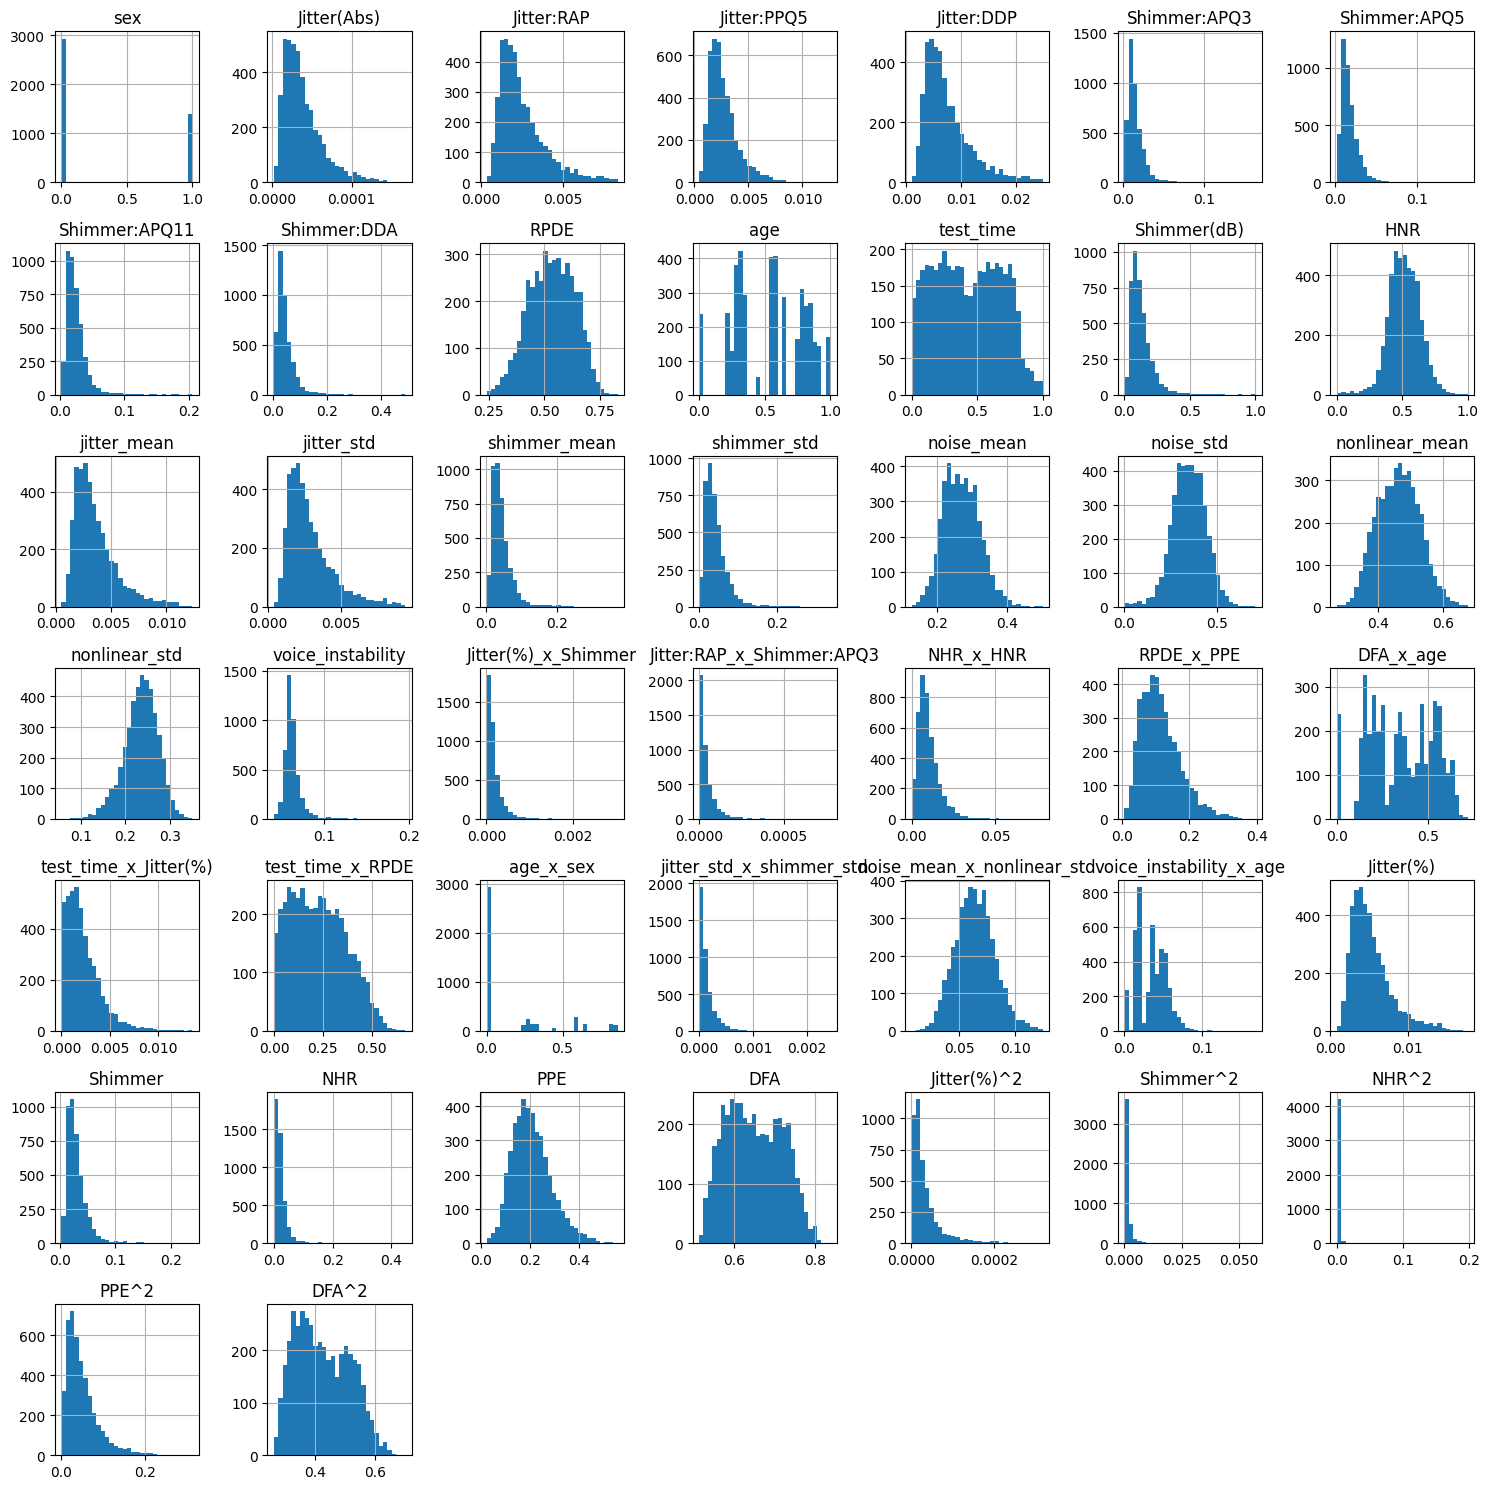

Skewness of features:
 NHR^2                         15.170195
Shimmer^2                      8.148695
NHR                            6.454374
jitter_std_x_shimmer_std       4.128144
Jitter(%)_x_Shimmer            4.077808
Jitter:RAP_x_Shimmer:APQ3      4.067983
voice_instability              3.104327
Shimmer:APQ11                  3.069720
Shimmer:APQ5                   2.865452
Shimmer                        2.768091
Shimmer:DDA                    2.748309
Shimmer:APQ3                   2.748257
Jitter(%)^2                    2.691087
shimmer_std                    2.656665
Shimmer(dB)                    2.640879
shimmer_mean                   2.634773
NHR_x_HNR                      2.100259
PPE^2                          1.756361
test_time_x_Jitter(%)          1.703871
Jitter:PPQ5                    1.663037
Jitter(Abs)                    1.484635
age_x_sex                      1.431921
Jitter:DDP                     1.427376
Jitter:RAP                     1.427367
jitter_std       

In [317]:
# check distribution and skewness of features

# Plot histograms for all features
X_train_engineered.hist(bins=30, figsize=(15, 15))
plt.tight_layout()
plt.show()

# Quantify skew (threshold: |skew| > 1 is significant)
skewness = X_train_engineered.skew()
print("Skewness of features:\n", skewness.sort_values(ascending=False))

### Tranformation

- Strong transform needed: skew > 2
- Moderate transform needed: skew <= 2
- No tranform needed: skew <= 1

Apply Yeo-Johnson tranform to all features with skewness above 1. These have significant skew, which can distort linear models and distance-based algorithms.

In [318]:
def apply_transformations(X_train, X_test, categorical_columns):
    # Identify numerical features
    numerical_columns = X_train.columns.difference(categorical_columns)
    
    # Apply PowerTransformer to moderately skewed features (|skew| > 0.5)
    skewness = X_train[numerical_columns].skew()
    to_transform = skewness[abs(skewness) > 0.5].index.tolist()
    
    pt = PowerTransformer(method='yeo-johnson')
    X_train_transformed = X_train.copy()
    X_test_transformed = X_test.copy()
    
    X_train_transformed[to_transform] = pt.fit_transform(X_train[to_transform])
    X_test_transformed[to_transform] = pt.transform(X_test[to_transform])
    
    # Further correct extreme skew 
    high_skew_post = X_train_transformed[numerical_columns].skew()
    to_log = high_skew_post[abs(high_skew_post) > 1].index.tolist()
    
    for feature in to_log:
        X_train_transformed[feature] = np.log1p(X_train_transformed[feature])
        X_test_transformed[feature] = np.log1p(X_test_transformed[feature])
    
    return X_train_transformed, X_test_transformed

In [319]:
categorical_columns = ['sex']  # Adjust this list if you have other categorical columns

# Apply PowerTransformer to the train and test sets
X_train_engineered, X_test_engineered = apply_transformations(X_train_engineered, X_test_engineered, categorical_columns)

In [320]:
transformed_skew = X_train_engineered.skew()
print("Max Skew After:", transformed_skew.abs().max())  # Should be < 0.5

Max Skew After: 0.8162043015233624


Top skewed features after transform:
 age_x_sex                    0.816204
sex                          0.766406
Shimmer^2                    0.675150
jitter_std_x_shimmer_std     0.450063
Jitter:RAP_x_Shimmer:APQ3    0.448975
nonlinear_std               -0.447584
Jitter(%)^2                  0.436162
Jitter(%)_x_Shimmer          0.386235
test_time_x_RPDE             0.321158
voice_instability_x_age      0.320092
dtype: float64


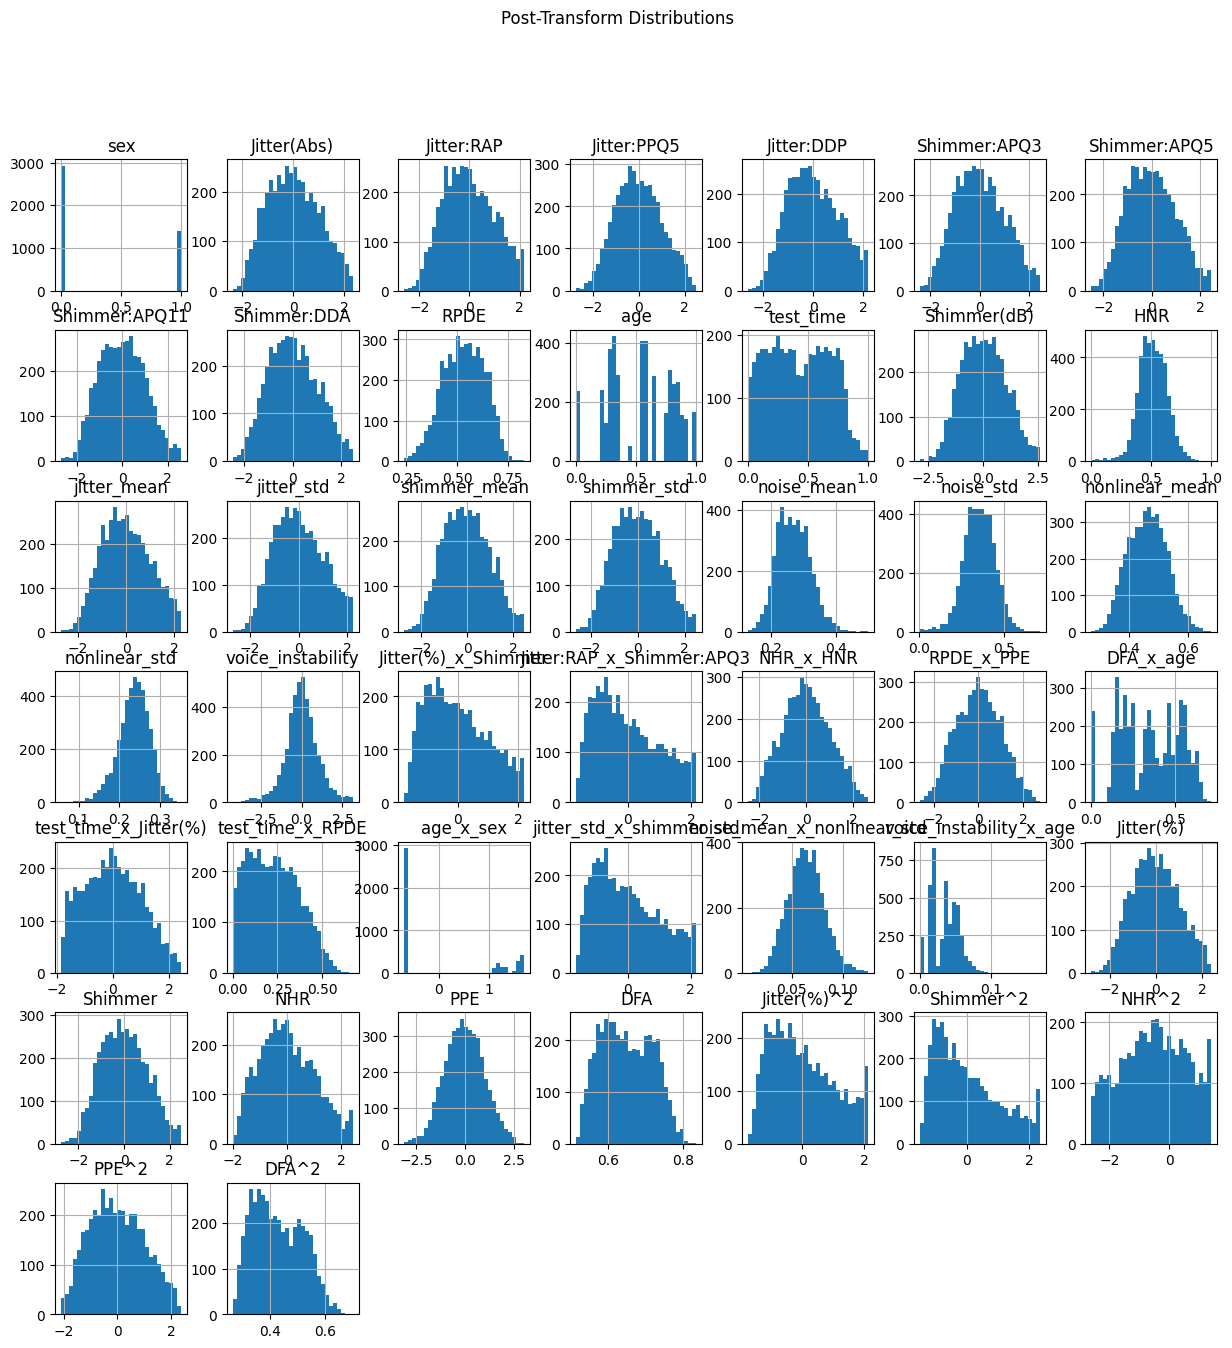

In [321]:
# Check post-transform skewness
skewness_after = X_train_engineered.skew().sort_values(key=abs, ascending=False)
print("Top skewed features after transform:\n", skewness_after.head(10))

# Plot histograms
X_train_engineered.hist(bins=30, figsize=(15, 15))
plt.suptitle("Post-Transform Distributions")
plt.show()

### Scaling

In [322]:
# All features already 0-1 (no action needed)
if (X_train_engineered.min().min() >= 0) and (X_train_engineered.max().max() <= 1):
    print("Data already normalized to [0,1] — no scaling needed.")
    
# Some features outside 0-1
else:
    scaler = MinMaxScaler(feature_range=(0, 1))
    X_train_scaled = scaler.fit_transform(X_train_engineered)
    X_test_scaled = scaler.transform(X_test_engineered)

In [323]:
X_test_engineered = pd.DataFrame(X_test_scaled, columns=X_train_engineered.columns, index=X_test_engineered.index)
X_train_engineered = pd.DataFrame(X_train_scaled, columns=X_train_engineered.columns, index=X_train_engineered.index)

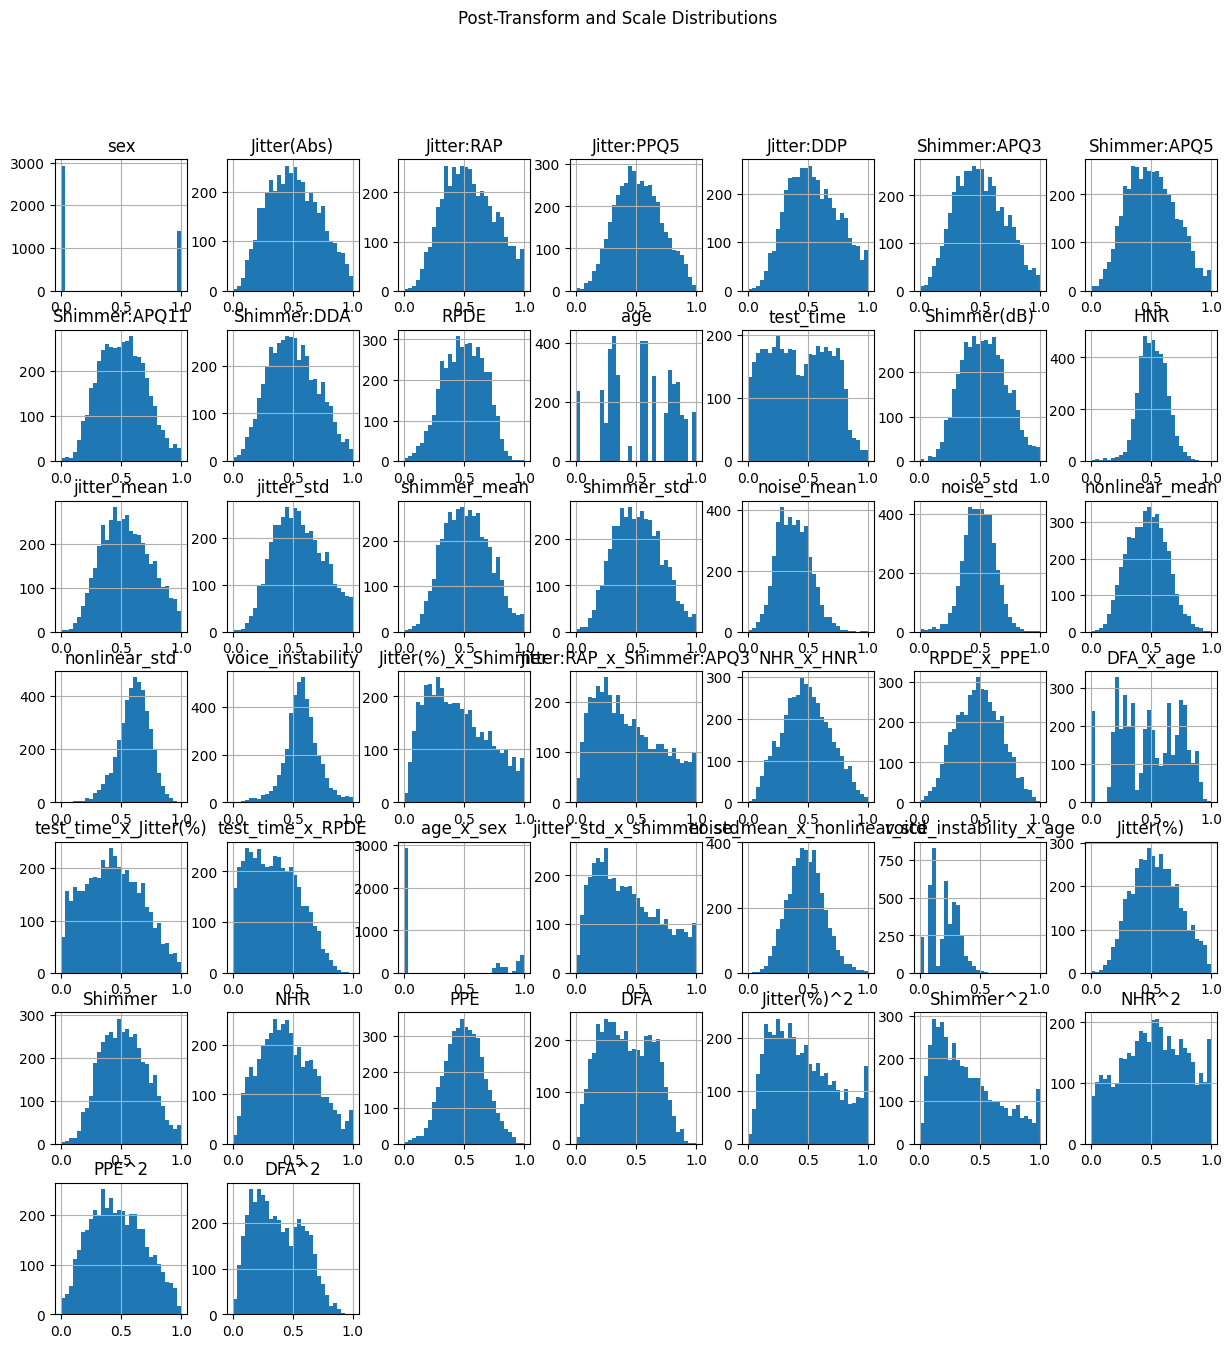

In [324]:
X_train_engineered.hist(bins=30, figsize=(15, 15))
plt.suptitle("Post-Transform and Scale Distributions")
plt.show()

# Result

In [325]:
# check if they improve prediction

print('Linear Regression model')

# Baseline (original features)
baseline = LinearRegression().fit(X_train_original, y_train_motor)
baseline_mae = mean_absolute_error(y_test_motor, baseline.predict(X_test_original))
baseline_mse = mean_squared_error(y_test_motor, baseline.predict(X_test_original))
baseline_r2 = r2_score(y_test_motor, baseline.predict(X_test_original))

# Engineered features
engineered = LinearRegression().fit(X_train_engineered, y_train_motor)
engineered_mae = mean_absolute_error(y_test_motor, engineered.predict(X_test_engineered))
engineered_mse = mean_squared_error(y_test_motor, engineered.predict(X_test_engineered))
engineered_r2 = r2_score(y_test_motor, engineered.predict(X_test_engineered))

print(f"Baseline MAE: {baseline_mae:.3f}")
print(f"Baseline MSE: {baseline_mse:.3f}")
print(f"Baseline R2: {baseline_r2:.3f}")
print(f"With New Features MAE: {engineered_mae:.3f}")
print(f"With New Features MSE: {engineered_mse:.3f}")
print(f"With New Features R2: {engineered_r2:.3f}")

Linear Regression model
Baseline MAE: 6.615
Baseline MSE: 55.254
Baseline R2: -0.719
With New Features MAE: 6.608
With New Features MSE: 55.258
With New Features R2: -0.719


In [326]:
# check if they improve prediction

# Baseline (original features)

print('Random Forest model')


baseline = RandomForestRegressor().fit(X_train_original, y_train_motor)
baseline_mae = mean_absolute_error(y_test_motor, baseline.predict(X_test_original))
baseline_mse = mean_squared_error(y_test_motor, baseline.predict(X_test_original))
baseline_r2 = r2_score(y_test_motor, baseline.predict(X_test_original))

# Engineered features
engineered = RandomForestRegressor().fit(X_train_engineered, y_train_motor)
engineered_mae = mean_absolute_error(y_test_motor, engineered.predict(X_test_engineered))
engineered_mse = mean_squared_error(y_test_motor, engineered.predict(X_test_engineered))
engineered_r2 = r2_score(y_test_motor, engineered.predict(X_test_engineered))

print(f"Baseline MAE: {baseline_mae:.3f}")
print(f"Baseline MSE: {baseline_mse:.3f}")
print(f"Baseline R2: {baseline_r2:.3f}")
print(f"With New Features MAE: {engineered_mae:.3f}")
print(f"With New Features MSE: {engineered_mse:.3f}")
print(f"With New Features R2: {engineered_r2:.3f}")

Random Forest model
Baseline MAE: 6.819
Baseline MSE: 62.599
Baseline R2: -0.948
With New Features MAE: 7.703
With New Features MSE: 78.302
With New Features R2: -1.437


We don't see improvements but that's because we still haven't applied feature selection. Feature Selection is applied in the feature selection notebook. Proceed there.

In [329]:
X_train_engineered.to_pickle('data/X_train_engineered.pkl')
X_test_engineered.to_pickle('data/X_test_engineered.pkl')